In [1]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_craft_md-0.2.5.tar.gz \
    https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_jnlpba_md-0.2.5.tar.gz \
    https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_bc5cdr_md-0.2.5.tar.gz \
    https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_bionlp13cg_md-0.2.5.tar.gz

     |████████████████████████████████| 79.9MB 381kB/s eta 0:00:017     |█████▏                          | 12.9MB 10.4MB/s eta 0:00:07     |████████                        | 19.9MB 1.3MB/s eta 0:00:47     |█████████████▉                  | 34.7MB 271kB/s eta 0:02:47     |███████████████▊                | 39.2MB 918kB/s eta 0:00:45     |█████████████████████▌          | 53.7MB 2.2MB/s eta 0:00:13     |██████████████████████▏         | 55.5MB 3.6MB/s eta 0:00:07     |██████████████████████▌         | 56.2MB 3.6MB/s eta 0:00:07     |███████████████████████▊        | 59.1MB 2.7MB/s eta 0:00:08     |████████████████████████▍       | 61.1MB 3.2MB/s eta 0:00:06     |████████████████████████▋       | 61.4MB 3.2MB/s eta 0:00:06
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_jnlpba_md-0.2.5.tar.gz
     |████████████████████████████████| 79.9MB 1.8MB/s eta 0:00:01     |██▏                             | 5.3MB 1.9MB/s eta 0:00:39     |███▋                  

  Created wheel for en-ner-bionlp13cg-md: filename=en_ner_bionlp13cg_md-0.2.5-cp37-none-any.whl size=80006785 sha256=0f72cc57d8b3c277432a7e12be62fb3b45707c3b6fbbc57a7d3362f0847c3051
  Stored in directory: /Users/edelattr/Library/Caches/pip/wheels/3e/de/7f/ce08b0072c9db43f2d252d84f88d458493abd5bd254c26e9ba
Successfully built en-ner-craft-md en-ner-jnlpba-md en-ner-bc5cdr-md en-ner-bionlp13cg-md
ERROR: bbsearch 0.1 has requirement spacy==2.2.1, but you'll have spacy 2.3.0 which is incompatible.
  Found existing installation: en-ner-craft-md 0.2.4
    Uninstalling en-ner-craft-md-0.2.4:
      Successfully uninstalled en-ner-craft-md-0.2.4
  Found existing installation: en-ner-bc5cdr-md 0.2.4
    Uninstalling en-ner-bc5cdr-md-0.2.4:
      Successfully uninstalled en-ner-bc5cdr-md-0.2.4
  Found existing installation: en-ner-bionlp13cg-md 0.2.4
    Uninstalling en-ner-bionlp13cg-md-0.2.4:
      Successfully uninstalled en-ner-bionlp13cg-md-0.2.4
You should consider upgrading via the 'pip ins

In [2]:
from collections import OrderedDict
from pathlib import Path
import sqlite3

import numpy as np
import pandas as pd
import spacy

from bbsearch.mining.eval import (prodigy2df, spacy2df, unique_etypes, plot_ner_confusion_matrix, 
                                  ner_report, ner_errors, remove_punctuation)

import matplotlib.pyplot as plt
%matplotlib inline

## Notebook parameters

In [5]:
SCISPACY_MODELS = ['en_ner_craft_md',
                   'en_ner_jnlpba_md',
                   'en_ner_bc5cdr_md',
                   'en_ner_bionlp13cg_md',
                  '../models/model1_bc5cdr_annotations5_spacy23/',
                  '../models/model2_craft_annotations6_spacy23/',
                  '../models/model5_jnlpba_annotations9_spacy23/']

PRODIGY_DB_PATH = Path('/raid/.prodigy/prodigy.db')
PRODIGY_DB_PATH = Path('prodigy.db')

# prodigy_dataset_name: annotator_name
DATASETS_2_ANNOTATORS = OrderedDict([('annotations3_EmmanuelleLogette_2020-07-06_raw1_8FirstLabels', 'EmmanuelleLogette'),
                                     ('annotations4_CharlotteLorin_2020-07-02_raw1_8FirstLabels', 'CharlotteLorin')])

annotators = list(DATASETS_2_ANNOTATORS.values())

## Import annotations from experts

In [6]:
db = sqlite3.connect(PRODIGY_DB_PATH)

df = OrderedDict([(annotator, prodigy2df(db, dataset_name=dataset)) 
                  for dataset, annotator in DATASETS_2_ANNOTATORS.items()])

# Drop useless columns
for annotator in annotators:
    df[annotator].drop(columns=['sentence_id'], inplace=True)

# Inner join: look at annotations for the same tokens (id) of the same sentences (source)
df = df[annotators[1]].merge(df[annotators[0]], 
                                 on=['source', 'id', 'text', 'start_char', 'end_char'], 
                                 suffixes=(f'_{annotators[1]}', f'_{annotators[0]}'),
                                 how='inner')

annotators_names = '\n - '.join(annotators)
print(f'Loaded annotations for {len(df):,d} tokens, provided by the following expert annotators:\n - {annotators_names}.')
display(df.head())

Loaded annotations for 10,320 tokens, provided by the following expert annotators:
 - EmmanuelleLogette
 - CharlotteLorin.


,source,class_CharlotteLorin,start_char,end_char,id,text,class_EmmanuelleLogette
0,CORD-19 - sentence 93,O,0,7,0,METHODS,O
1,CORD-19 - sentence 93,O,7,8,1,:,O
2,CORD-19 - sentence 93,O,9,10,2,A,O
3,CORD-19 - sentence 93,O,11,16,3,total,O
4,CORD-19 - sentence 93,O,17,19,4,of,O


## Add annotations predicted by SciSpaCy models

<div>
<strong> Attention! (1) </strong> 
<br>
    Predicted annotations must be generated like here by calling the SciSpaCy models on the text, sentence by sentence. Doing a batch inference on the whole <code>df['text']</code> column would allow the models to look outside of the boundaries of sentences, so that the predictions would be affected by the order of the sentence in the dataframe.
    </div>
    
    
<div>
<strong> Attention! (2) </strong>
<br>
    In many cases the entity type names in the predicted annotations do not match the ones in the ground truth. To fix that, most evaluation function support a dictionary parameter <code>etypes_map</code>.
</div>

In [7]:
ner_models = {model_name: spacy.load(model_name) for model_name in SCISPACY_MODELS}

# Add columns with predictions of NER models
for ner_model_name, ner_model in ner_models.items():
    model_df = []

    for source, df_ in df.groupby('source'):
        df_ = df_.sort_values(by='id', inplace=False, ignore_index=True)
        df_sentence = spacy2df(spacy_model=ner_model, ground_truth_tokenization=df_['text'].to_list())
        df_sentence['id'] = df_['id'].values
        df_sentence['source'] = source
        model_df.append(df_sentence)

    model_df = pd.concat(model_df, ignore_index=True)
    model_df.rename(columns={'class': f'class_{ner_model_name}'}, inplace=True)
    
    df = df.merge(model_df, 
         on=['source', 'id', 'text'], 
         how='inner')
    
scispacy_models_names = "\n - ".join(SCISPACY_MODELS)
print(f'Added annotations for {len(df):,d} tokens, predicted by' \
      f'the following NER models: \n - {scispacy_models_names}.')
display(df.head())

Added annotations for 10,320 tokens, predicted bythe following NER models: 
 - en_ner_craft_md
 - en_ner_jnlpba_md
 - en_ner_bc5cdr_md
 - en_ner_bionlp13cg_md
 - ../models/model1_bc5cdr_annotations5_spacy23/
 - ../models/model2_craft_annotations6_spacy23/
 - ../models/model5_jnlpba_annotations9_spacy23/.


,source,class_CharlotteLorin,start_char,end_char,id,text,class_EmmanuelleLogette,class_en_ner_craft_md,class_en_ner_jnlpba_md,class_en_ner_bc5cdr_md,class_en_ner_bionlp13cg_md,class_../models/model1_bc5cdr_annotations5_spacy23/,class_../models/model2_craft_annotations6_spacy23/,class_../models/model5_jnlpba_annotations9_spacy23/
0,CORD-19 - sentence 93,O,0,7,0,METHODS,O,O,O,O,O,O,O,O
1,CORD-19 - sentence 93,O,7,8,1,:,O,O,O,O,O,O,O,O
2,CORD-19 - sentence 93,O,9,10,2,A,O,O,O,O,O,O,O,O
3,CORD-19 - sentence 93,O,11,16,3,total,O,O,O,O,O,O,O,O
4,CORD-19 - sentence 93,O,17,19,4,of,O,O,O,O,O,O,O,O


## NER Evaluation

The following NER evaluation functions have a parameter <code>mode</code> which can take one of the two following values.
<ul>
    <li><code>"token"</code>: Each token is considered separately, and only the enity type (e.g. <code>"DISEASE"</code>) of annotations is considered, without considering the full IOB annotations (e.g. <code>"B-DISEASE"</code>).</li>
    <li><code>"entity"</code>: Entities are considered as units, even if they cover a span of several tokens. A True Positive is defined as two entity annotations matching exactly from the first to the last token of the span.</li>

</ul>

<div>
<strong>Note.</strong> For the purpose of the evaluations shown in this section, we will consider the evaluations of <code>EmmanuelleLogette</code> as the ground truth. The resports are therefore produced with respect to the labels used by this annoator.
</div>

<div>
<strong>Note.</strong> Annotation of punctuation elements as parts of an entity can orginiate from small mistakes in the manual labeling process. For this reason, we can remove all punctuation elements by calling <code>remove_punctuation()</code>.
</div>

In [8]:
df = remove_punctuation(df)

### <code>unique_etypes</code>: analyze distribution annotations per entity type

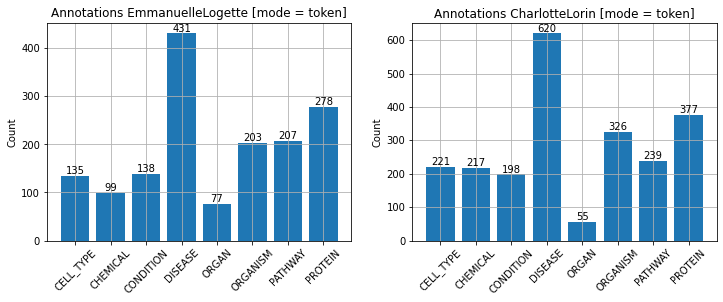

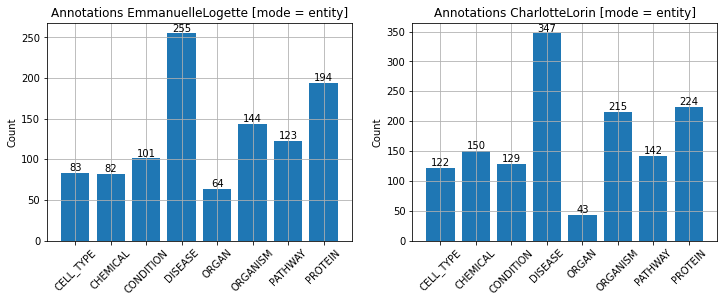

In [13]:
model = annotators[1]
for mode in ('token', 'entity'):
    f, ax = plt.subplots(1, 2, figsize=(12, 4))
    for ax_, annotator in zip(ax, (annotators[0], model)):
        iob_annotations = df[f'class_{annotator}']
        etypes, counts = unique_etypes(iob_annotations, mode=mode, return_counts=True)
        ax_.bar(etypes, counts)
        for x, y in enumerate(counts):
            ax_.text(x, y, f'{y:,d}', ha='center', va='bottom')
        ax_.set_xticklabels(etypes, rotation=45)
        ax_.set_ylabel('Count')
        ax_.grid()
        ax_.set_title(f'Annotations {annotator} [mode = {mode}]')

### <code>ner_report</code>: summarize ner scores

<strong>Note.</strong> If one needs to access exact numeric values of the report, it is possible to call the function with <code>return_dict=True</code>.

In [28]:
iob_true = df[f'class_{annotators[0]}']


for mode in ('token', 'entity'):
    for annotator_pred in (annotators[1], SCISPACY_MODELS[5]):
        print(f'Annotations {annotator_pred} [mode = {mode}]')
        iob_pred = df[f'class_{annotator_pred}']
        if annotator_pred in SCISPACY_MODELS:
            print(ner_report(iob_true, iob_pred, mode=mode, return_dict=False, 
                             etypes_map={'CHEMICAL': 'CHEBI',
                                         'CELL_TYPE': 'CL',
                                         'ORGANISM': 'TAXON',
                                         'PROTEIN': 'GGP'}))
        else:
            print(ner_report(iob_true, iob_pred, mode=mode, return_dict=False))      
        print()
    print()

Annotations CharlotteLorin [mode = token]
           precision    recall  f1-score   support
     CHEBI      0.00      0.00      0.00       181
        CL      0.00      0.00      0.00       182
       GGP      0.00      0.00      0.00       240
        GO      0.00      0.00      0.00        31
        SO      0.00      0.00      0.00        90
     TAXON      0.00      0.00      0.00       183

Annotations ../models/model2_craft_annotations6_spacy23/ [mode = token]
           precision    recall  f1-score   support
     CHEBI      0.64      0.66      0.65       181
        CL      0.00      0.00      0.00       182
       GGP      0.00      0.00      0.00       240
        GO      0.00      0.00      0.00        31
        SO      0.00      0.00      0.00        90
     TAXON      0.53      0.85      0.66       183


Annotations CharlotteLorin [mode = entity]
           precision    recall  f1-score   support
     CHEBI      0.00      0.00      0.00       159
        CL      0.00    

In [ ]:
Added annotations for 10,320 tokens, predicted bythe following NER models: 
 - en_ner_craft_md
 - en_ner_jnlpba_md
 - en_ner_bc5cdr_md
 - en_ner_bionlp13cg_md
 - ../models/model1_bc5cdr_annotations5_spacy23/
 - ../models/model2_craft_annotations6_spacy23/
 - ../models/model5_jnlpba_annotations9_spacy23/.


etype_name, model_before, model_after, etypes_map 
CELL_TYPE: jnlpba CHEMICAL: craft CONDITION: n.a. 
            DISEASE: bc5cdr ORGAN: bionlp13cg ORGANISM: 
                        craft PATHWAY: n.a. PROTEIN: jnlpba

In [43]:
columns = ['entity_type', 'model_before', 'model_after', 'etypes_map']
    
data = []
data.append({'entity_type': 'CELL_TYPE',
            'model_before': 'en_ner_jnlpba_md',
            'model_after': 'model5_jnlpba_annotations9_spacy23', 
             'etypes_map': {}})

data.append({'entity_type': 'CHEMICAL',
            'model_before': 'en_ner_craft_md',
            'model_after': 'model2_craft_annotations6_spacy23', 
             'etypes_map': {'CHEMICAL': 'CHEBI'}})

data.append({'entity_type': 'DISEASE',
            'model_before': 'en_ner_bc5cdr_md',
            'model_after': 'model1_bc5cdr_annotations5_spacy23', 
             'etypes_map': {}})

data.append({'entity_type': 'ORGAN',
            'model_before': 'en_ner_bionlp13cg_md',
            'model_after': None, 
             'etypes_map': {}})

data.append({'entity_type': 'ORGANISM',
            'model_before': 'en_ner_craft_md',
            'model_after': 'model2_craft_annotations6_spacy23', 
             'etypes_map': {'ORGANISM': 'TAXON'}})

data.append({'entity_type': 'PROTEIN',
            'model_before': 'en_ner_jnlpba_md',
            'model_after': 'model5_jnlpba_annotations9_spacy23', 
             'etypes_map': {}})

modes = ['token', 'entity']
scores = ['precision', 'recall', 'f1-score', 'support']
bas = ['before', 'after', 'baseline']
columns.extend([f'{mode}_{score}_{ba}' for score in scores for mode in modes for ba in bas])

models = pd.DataFrame(data, columns=columns)
display(models)

,entity_type,model_before,model_after,etypes_map,token_precision_before,token_precision_after,token_precision_baseline,entity_precision_before,entity_precision_after,entity_precision_baseline,...,token_f1-score_baseline,entity_f1-score_before,entity_f1-score_after,entity_f1-score_baseline,token_support_before,token_support_after,token_support_baseline,entity_support_before,entity_support_after,entity_support_baseline
0,CELL_TYPE,en_ner_jnlpba_md,model5_jnlpba_annotations9_spacy23,{},NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHEMICAL,en_ner_craft_md,model2_craft_annotations6_spacy23,{'CHEMICAL': 'CHEBI'},NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DISEASE,en_ner_bc5cdr_md,model1_bc5cdr_annotations5_spacy23,{},NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ORGAN,en_ner_bionlp13cg_md,None,{},NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ORGANISM,en_ner_craft_md,model2_craft_annotations6_spacy23,{'ORGANISM': 'TAXON'},NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PROTEIN,en_ner_jnlpba_md,model5_jnlpba_annotations9_spacy23,{},NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
iob_true = df[f'class_{annotators[0]}']

for mode in ['token', 'entity']:
    for index, row in models.iterrows():
        iob_pred = df[f'class_{row["model_before"]}']
        results_before = ner_report(iob_true, iob_pred, mode=mode, return_dict=True, 
                                    etypes_map=row['etypes_map'])
        results_before = results_before[row['entity_type']]
        for key, value in results_before.items():
            models.iloc[index, models.columns.get_loc(f'{mode}_{key}_before')] = value
            
        if row['model_after'] is not None:
            iob_pred = df[f'class_../models/{row["model_after"]}/']
            results_after = ner_report(iob_true, iob_pred, mode=mode, return_dict=True, 
                                       etypes_map=row['etypes_map'])
            results_after = results_after[row['entity_type']]
            for key, value in results_after.items():
                models.iloc[index, models.columns.get_loc(f'{mode}_{key}_after')] = value
                
        iob_pred = df[f'class_{annotators[1]}']
        results_baseline = ner_report(iob_true, iob_pred, mode=mode, return_dict=True)
        results_baseline = results_baseline[row['entity_type']]
        for key, value in results_baseline.items():
            models.iloc[index, models.columns.get_loc(f'{mode}_{key}_baseline')] = value

In [45]:
display(models)

,entity_type,model_before,model_after,etypes_map,token_precision_before,token_precision_after,token_precision_baseline,entity_precision_before,entity_precision_after,entity_precision_baseline,...,token_f1-score_baseline,entity_f1-score_before,entity_f1-score_after,entity_f1-score_baseline,token_support_before,token_support_after,token_support_baseline,entity_support_before,entity_support_after,entity_support_baseline
0,CELL_TYPE,en_ner_jnlpba_md,model5_jnlpba_annotations9_spacy23,{},0.742188,0.587678,0.583710,0.666667,0.539216,0.557377,...,0.724719,0.590604,0.594595,0.663415,135.0,135.0,135.0,83.0,83.0,83.0
1,CHEMICAL,en_ner_craft_md,model2_craft_annotations6_spacy23,"{'CHEMICAL': 'CHEBI', 'CONDITION': 'CONDITION'...",0.254144,0.372340,0.341014,0.238994,0.324675,0.360000,...,0.468354,0.315353,0.423729,0.465517,99.0,99.0,99.0,82.0,82.0,82.0
2,DISEASE,en_ner_bc5cdr_md,model1_bc5cdr_annotations5_spacy23,{},0.563183,0.624561,0.664516,0.498701,0.575668,0.610951,...,0.784015,0.600000,0.655405,0.704319,431.0,431.0,431.0,255.0,255.0,255.0
3,ORGAN,en_ner_bionlp13cg_md,None,{},0.440678,NaN,0.872727,0.406780,NaN,0.837209,...,0.727273,0.390244,NaN,0.672897,77.0,NaN,77.0,64.0,NaN,64.0
4,ORGANISM,en_ner_craft_md,model2_craft_annotations6_spacy23,"{'ORGANISM': 'TAXON', 'CHEMICAL': 'CHEMICAL', ...",0.404372,0.523973,0.576687,0.315152,0.435345,0.534884,...,0.710775,0.336570,0.537234,0.640669,203.0,203.0,203.0,144.0,144.0,144.0
5,PROTEIN,en_ner_jnlpba_md,model5_jnlpba_annotations9_spacy23,{},0.367673,0.396761,0.517241,0.361111,0.340237,0.544643,...,0.595420,0.451737,0.432331,0.583732,278.0,278.0,278.0,194.0,194.0,194.0


In [78]:
models.to_csv('Results_bef_aft_2020-07-14.csv')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


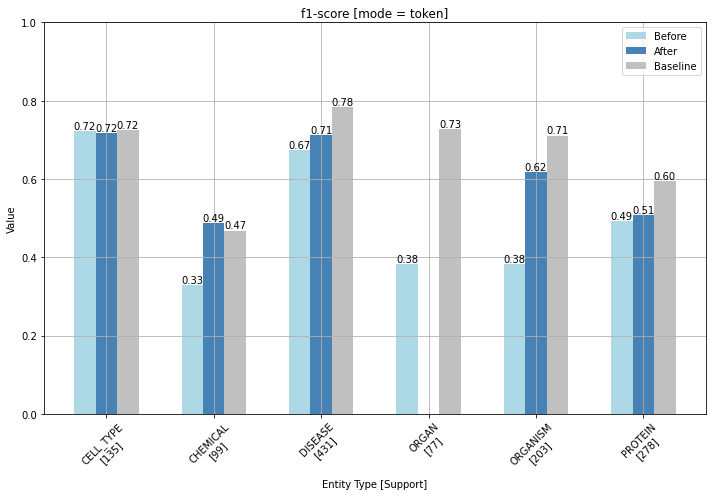

posx and posy should be finite values
posx and posy should be finite values


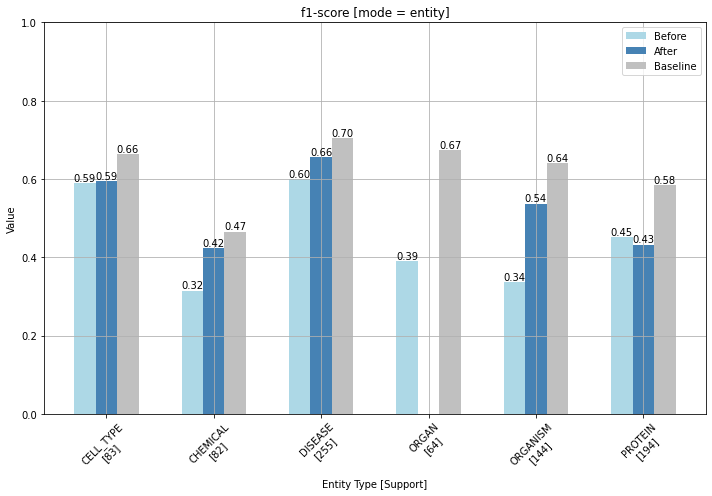

In [77]:
for mode in ('token', 'entity'):
    for score in ['f1-score']:
        f, ax = plt.subplots(1, 1, figsize=(10, 7))
        x = np.arange(len(models['entity_type']))
        
        ax.bar(x - 0.2, models[f'{mode}_{score}_before'], width=0.2, label='Before', color='lightblue')
        for x_, y_ in enumerate(models[f'{mode}_{score}_before']):
            ax.text(x_ - 0.2, y_, f'{y_:.2f}', ha='center', va='bottom')
            
        ax.bar(x, models[f'{mode}_{score}_after'], width=0.2, label='After', color='steelblue')
        for x_, y_ in enumerate(models[f'{mode}_{score}_after']):
            ax.text(x_, y_, f'{y_:.2f}', ha='center', va='bottom')
            
        ax.bar(x + 0.2, models[f'{mode}_{score}_baseline'], width=0.2, label='Baseline', color='silver')
        for x_, y_ in enumerate(models[f'{mode}_{score}_baseline']):
            ax.text(x_ + 0.2, y_, f'{y_:.2f}', ha='center', va='bottom')
        
        ax.legend()
        ax.set_xticks(x)
        ax.set_xticklabels([f'{etype}\n[{int(support)}]' for etype, support in zip(models['entity_type'], models[f'{mode}_support_before'])], rotation=45)
        ax.set_xlabel('Entity Type [Support]')
        ax.set_ylabel('Value')
        ax.set_ylim([0, 1])
        ax.grid()
        ax.set_title(f'{score} [mode = {mode}]')
        f.tight_layout()
        f.savefig(f'results_f1score_{mode}.png', dpi=200)

### <code>ner_errors</code>: show false negatives and false positives

<strong>Note.</strong> For reasons of space, we only print results relative to one entity type, but you can change the value of <code>"ETYPE"</code> to see the other results.

In [23]:
ETYPE = 'CELL_TYPE'

iob_true = df[f'class_{annotators[0]}']

for mode in ('token', 'entity'):
    for annotator_pred in (annotators[1], SCISPACY_MODELS[0]):
        print(f'Annotations {annotator_pred} [mode = {mode}]')
        iob_pred = df[f'class_{annotator_pred}']
        if annotator_pred in SCISPACY_MODELS:
            results_dict = ner_errors(iob_true, iob_pred, mode=mode, return_dict=True, 
                             etypes_map={'CHEMICAL': 'CHEBI',
                                         'CELL_TYPE': 'CL',
                                         'ORGANISM': 'TAXON',
                                         'PROTEIN': 'GGP'},
                            tokens=df.text)
        else:
            results_dict = ner_errors(iob_true, iob_pred, mode=mode, return_dict=True, tokens=df.text)
        print(f'------Entity type: {ETYPE}------')
        print(f'--- False Negatives ---')
        print(' '.join(repr(s) for s in results_dict[ETYPE]['false_neg']))
        print(f'--- False Positives ---')
        print(' '.join(repr(s) for s in results_dict[ETYPE]['false_pos']))
        print()
    print()

Annotations CharlotteLorin [mode = token]
------Entity type: CELL_TYPE------
--- False Negatives ---
'PBMCs' 'cells' 'epithelial' 'leukocyte' 'respiratory' 'splenocyte'
--- False Positives ---
'2' 'Bcl-2-expressing' 'CD11b' 'CD44' 'CG' 'CG-4' 'CG-4' 'Cells' 'Chinese' 'HCT' 'Human' 'Liver' 'Marc-145' 'PAMs' 'RBL)-2H3' 'T' 'T' 'Tbk1-deficient' 'airway' 'basophilic' 'bat' 'bat' 'bronchiolar' 'cell' 'cell' 'cell' 'cell' 'cell' 'cell' 'cell' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'cells' 'central' 'culture' 'cultures' 'cultures' 'embryonic' 'embryonic' 'endothelium' 'epithelia' 'epithelium' 'ganglion' 'glial' 'glial)-4' 'hCG' 'hematopoietic' 'host' 'kidney' 'kidney' 'layer' 'leukemia' 'lines' 'lymphocyte' 'mammalian' 'mononuclear' 'mouse' 'mucosal' 'neural' 'neuron' 'porcine' 'porcine' 'precursors' 'precursors' 'rat' 'the' 'transplant' 'tumor' 'typ

### <code>ner_confusion_matrix</code>: breakdown ner predictions against ground truth

<div>
<strong>Note.</strong> The function <code>plot_ner_confusion_matrix</code> is just a wrapper around <code>ner_confusion_matrix</code>.
</div>
<div>
<strong>Note.</strong> The normalization parameter <code>normalize</code> can take 4 possible values: <code>None, "true", "pred", "all"</code>.
</div>

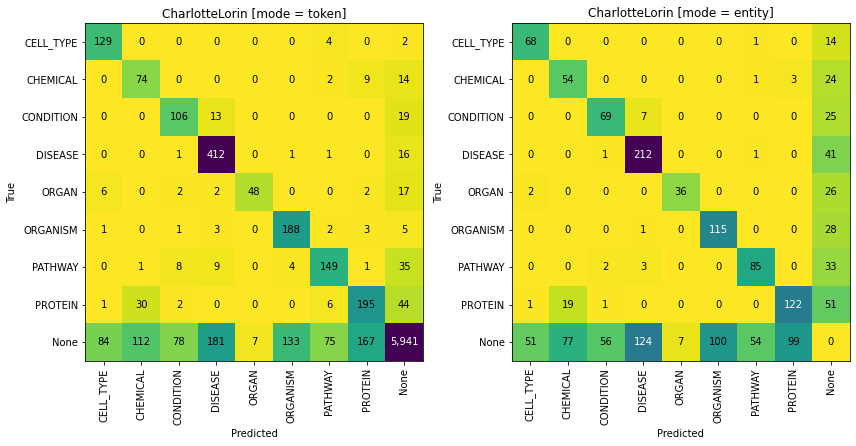

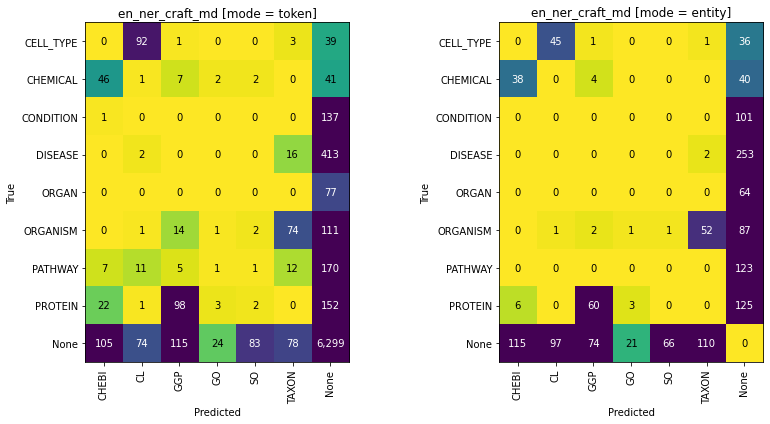

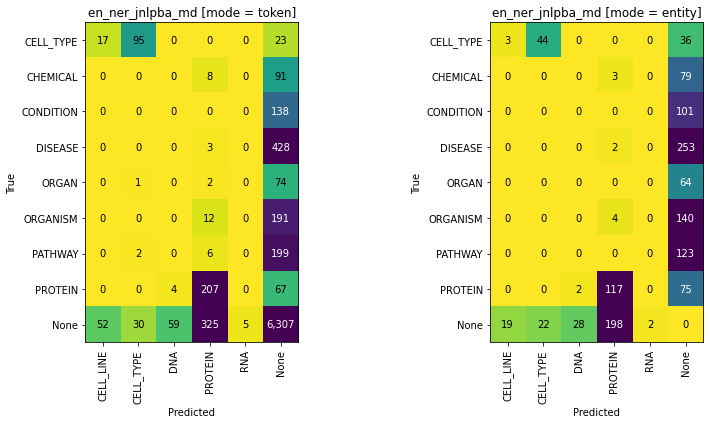

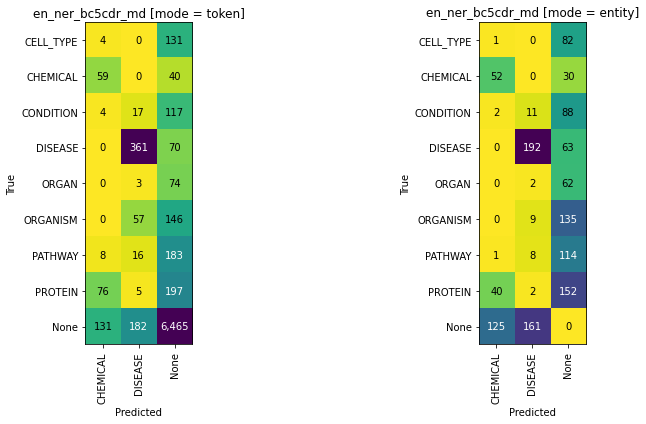

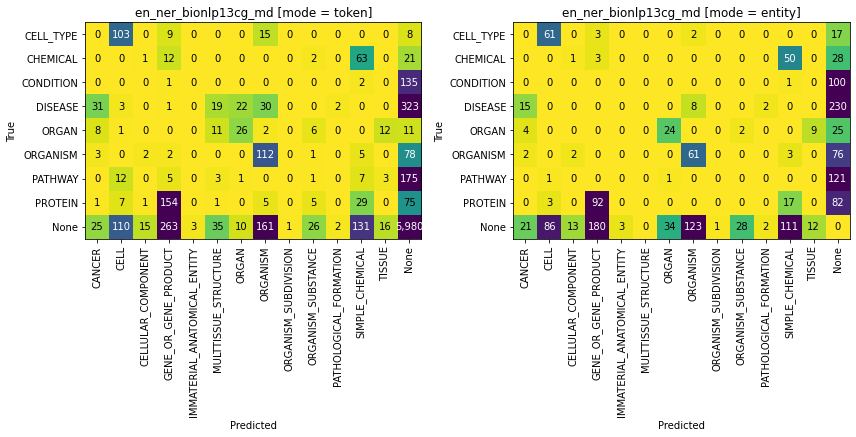

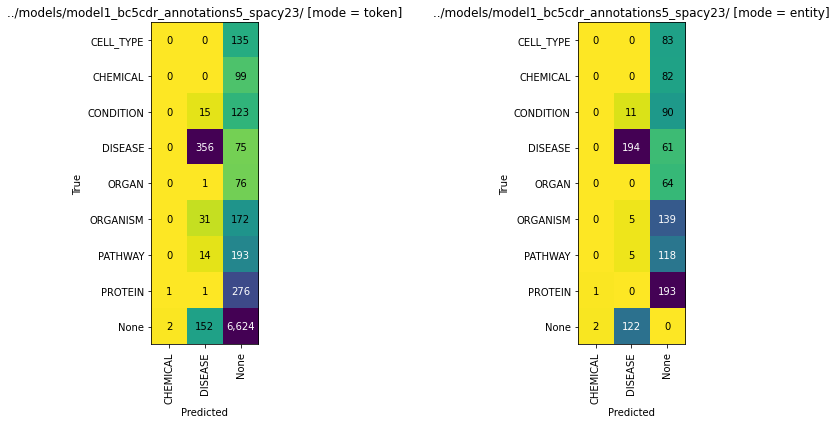

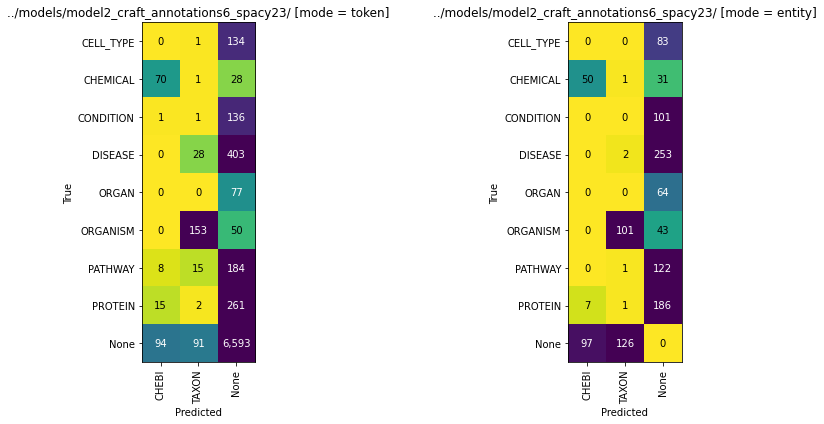

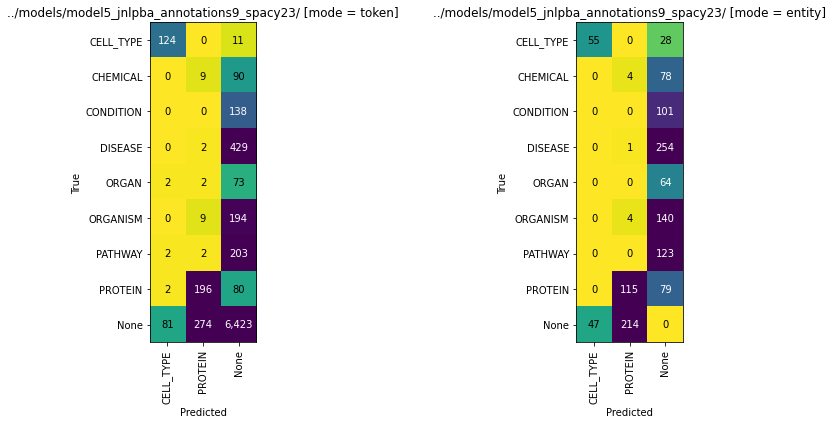

In [12]:
iob_true = df[f'class_{annotators[0]}']

for annotator_pred in (annotators[1], *SCISPACY_MODELS):
    iob_pred = df[f'class_{annotator_pred}']

    f, ax = plt.subplots(1, 2, figsize=(12, 6))
    for ax_, mode in zip(ax, ('token', 'entity')):
        plot_ner_confusion_matrix(iob_true, iob_pred, mode=mode, ax=ax_, normalize=None)
        ax_.set_title(f'{annotator_pred} [mode = {mode}]')
    f.tight_layout()